# Basic Strategy

In [523]:
%reload_ext autoreload
%autoreload 2
from init_strategy import generate_basic_strategy
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from env import BaseState, Action
from utils import *



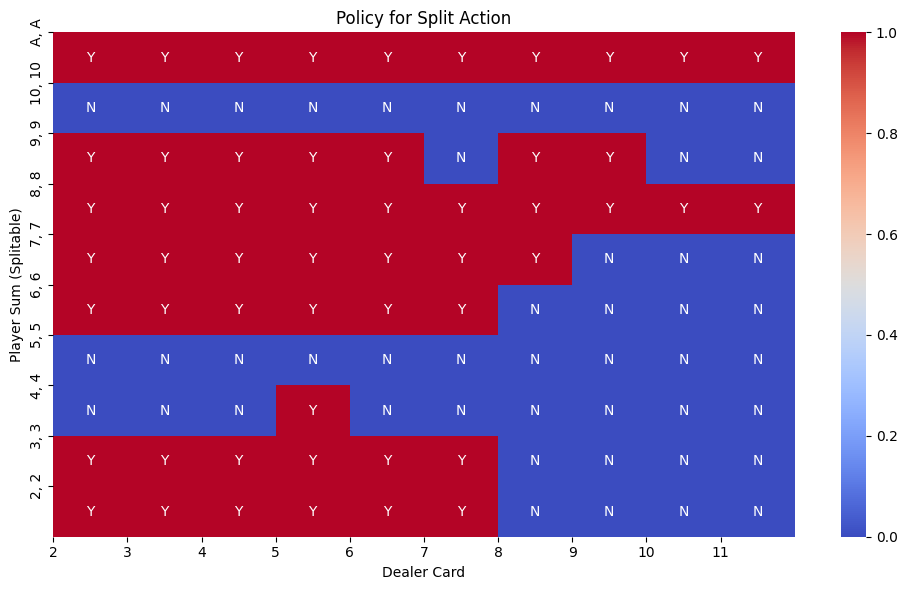

In [524]:
basic_policy = generate_basic_strategy()

# splitting
plot_split_policy(basic_policy)

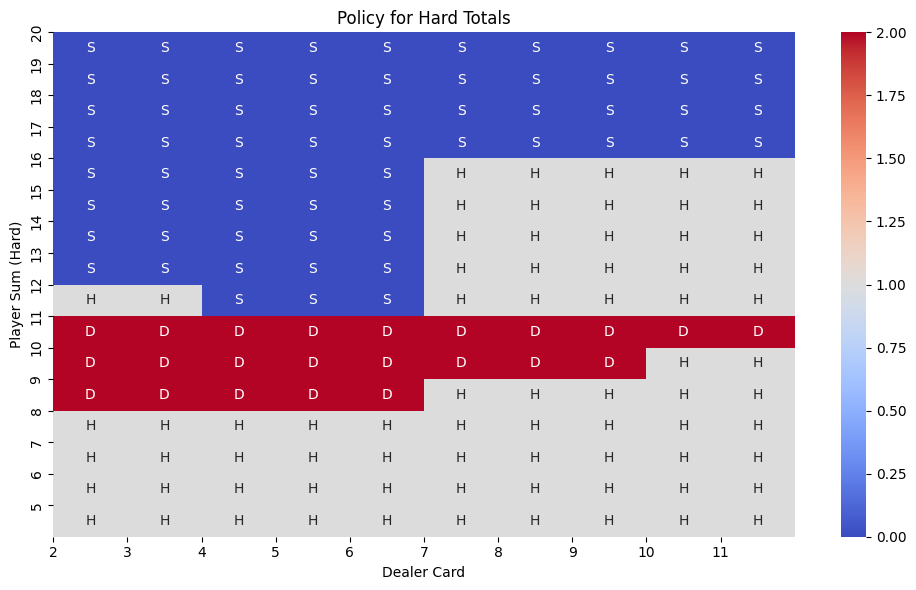

In [525]:
# hard totals
plot_hard_total_policy(basic_policy)

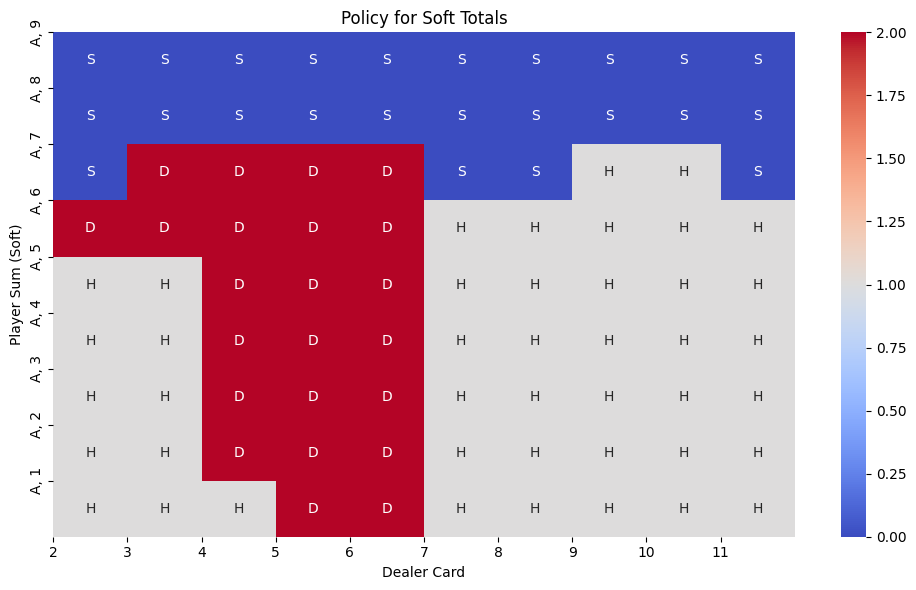

In [526]:
# soft totals
plot_soft_total_policy(basic_policy)

# Load Trained Q and Policy

In [ ]:
import pickle

# agent_name = "DoubleQLearningWithBasicLongRun1"
# agent_name = "agent_MCES3_without_double"
agent_name = "MCES_StandHitStand"

save_path = f"results/{agent_name}"

with open(f"{save_path}/policy.pkl", "rb") as f:
    policy = pickle.load(f)
with open(f"{save_path}/Q.pkl", "rb") as f:
    Q = pickle.load(f)

print(policy)
print(Q)

# for s, a in Q:
#     print(f"State: {s}, Action: {a}, Q-value: {Q[(s, a)]}")

# for s in policy:
#     print(f"State: {s}, Action: {policy[s]}")

{BaseState(player_sum=20, dealer_card=2, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=18, dealer_card=6, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=11, dealer_card=4, usible_ace=False, splitable=False, can_double=False): <Action.Hit: 1>, BaseState(player_sum=18, dealer_card=11, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=20, dealer_card=3, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=17, dealer_card=10, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=10, dealer_card=5, usible_ace=False, splitable=False, can_double=False): <Action.Stand: 0>, BaseState(player_sum=14, dealer_card=4, usible_ace=False, splitable=False, can_double=False): <Action.Hit: 1>, BaseState(player_sum=17, dealer_card=7, usible_ace=False, splitable=False, can_double=False): <Ac

# Show Optimal Policy
## Split Policy

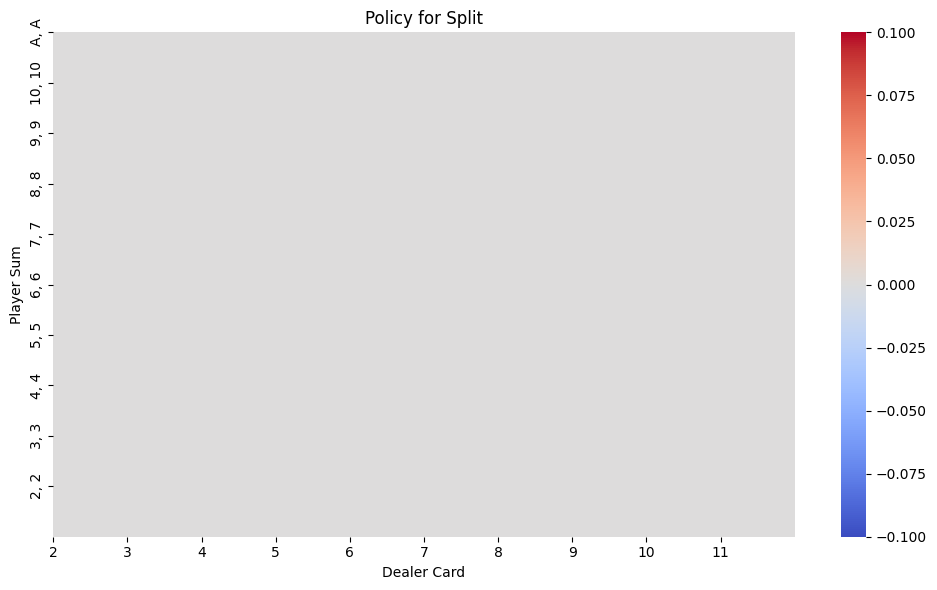

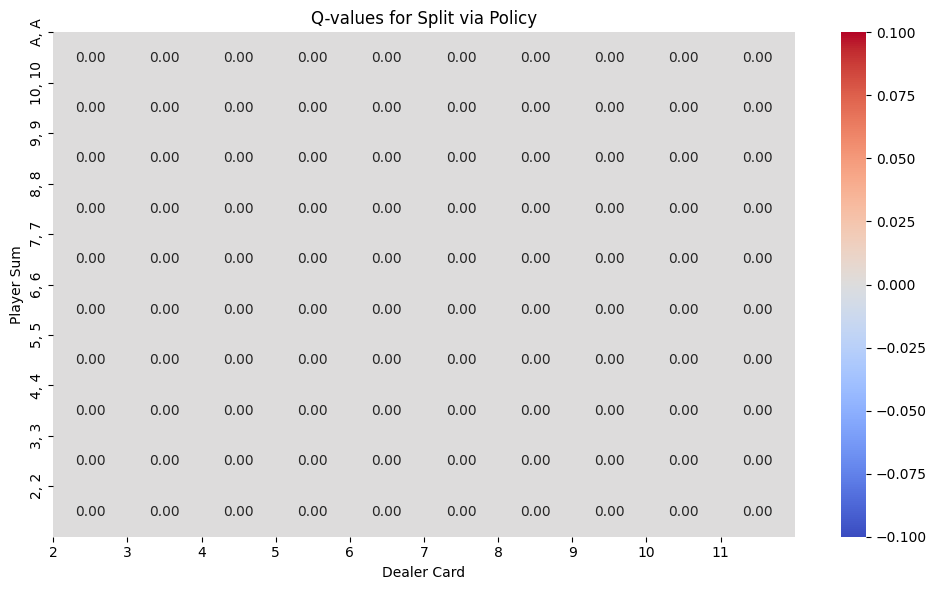

In [528]:
# plot_split_policy(policy)
plot_policy_and_Q(Q,policy, ChartName.Split, True)

## Soft Totals
Player has soft Ace

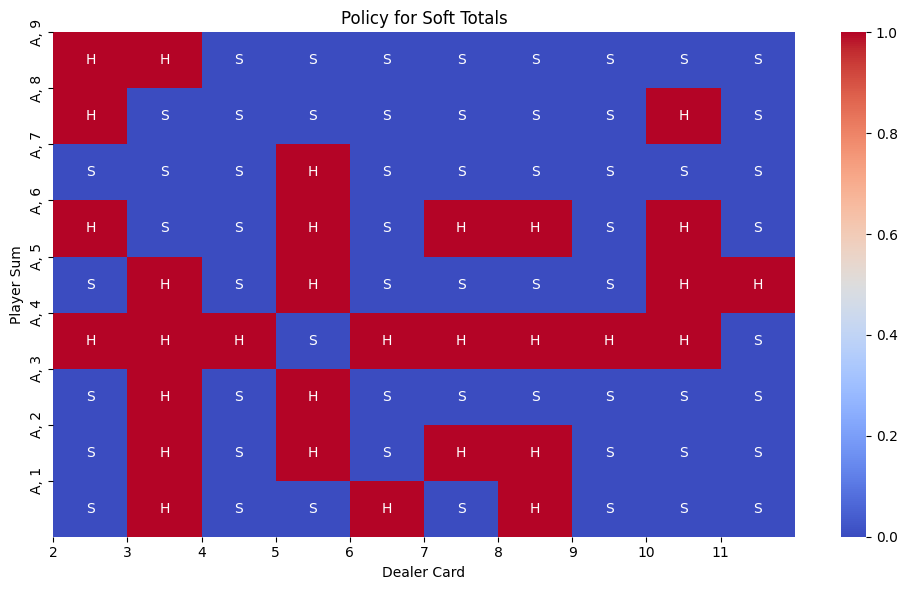

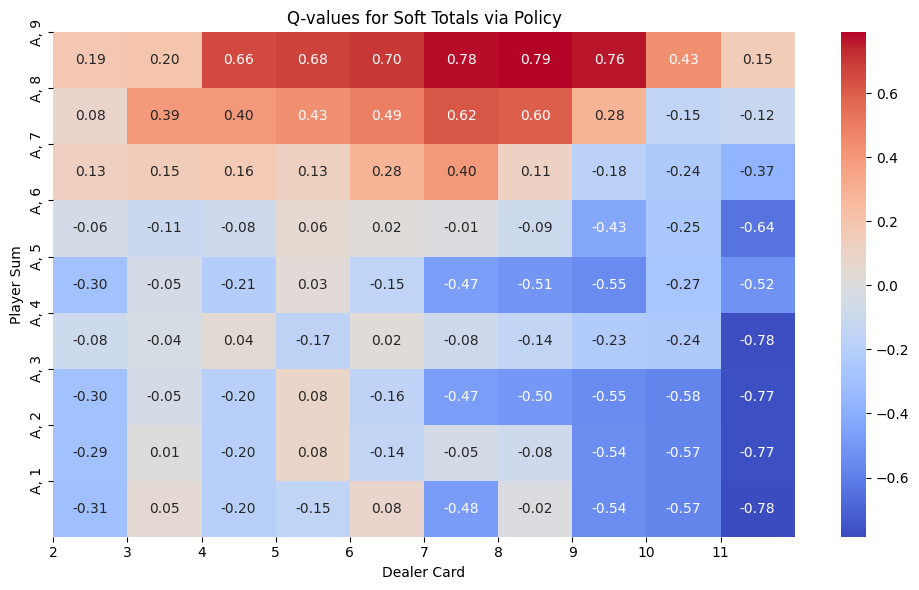

In [529]:
plot_policy_and_Q(Q,policy, ChartName.SoftTotals, can_double=False)

# Hard Totals

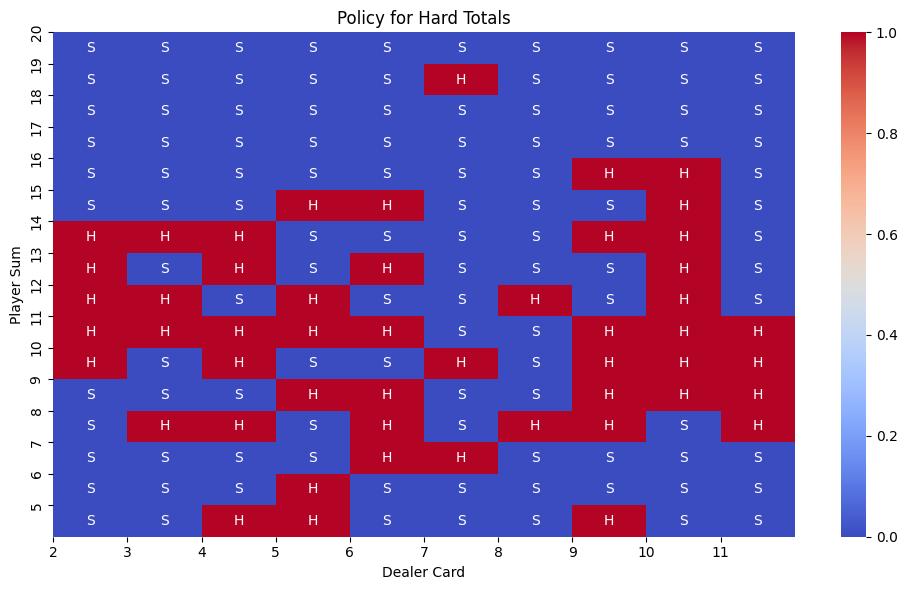

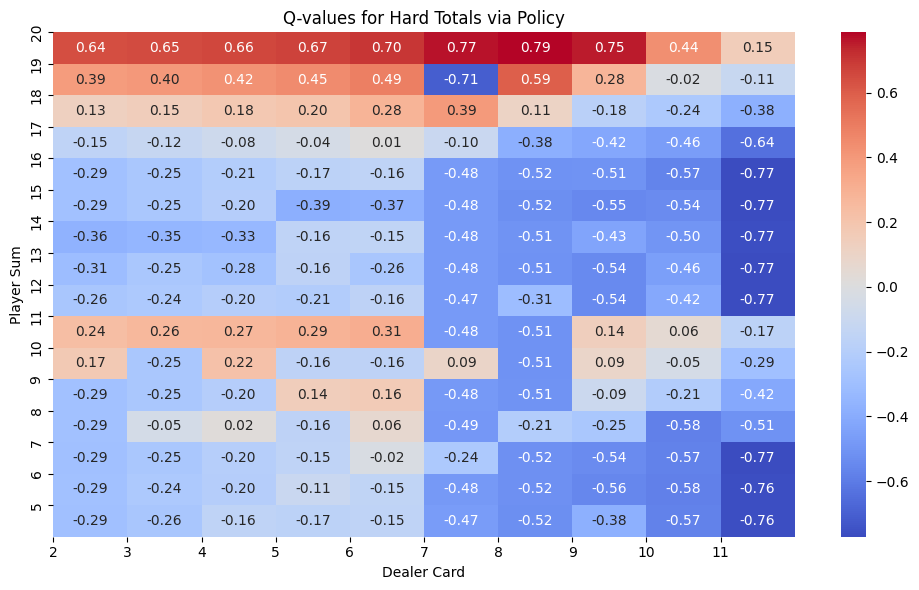

In [530]:
plot_policy_and_Q(Q, policy, ChartName.HardTotals,can_double=False)